# Example Q5: Experiment Sweeps
This example notebook shows how to add sweeps to Auspex qubit experiments

(c) Raytheon BBN Technologies 2018

First we ask auspex to run in dummy mode, which avoids loading instrument drivers.

In [1]:
import auspex.config as config
config.auspex_dummy_mode = True

In [2]:
from QGL import *
from auspex.qubit import *

Defaulting to temporary directory for AWG sequence file outputs.


auspex-WARNING: 2019-03-08 10:07:30,785 ----> Could not load channelizer library; falling back to python methods.


Channel library setup

In [3]:
cl = ChannelLibrary(db_resource_name=":memory:")
pl = PipelineManager()

q1 = cl.new_qubit("q1")
aps2_1 = cl.new_APS2("BBNAPSa", address="192.168.2.4", trigger_interval=200e-6) 
aps2_2 = cl.new_APS2("BBNAPSb", address="192.168.2.2")
dig_1  = cl.new_Alazar("Alazar_1", address="1", sampling_rate=500e6, record_length=1024)
h1 = cl.new_source("Holz_1", "HolzworthHS9000", "HS9004A-009-1", reference='10MHz', power=-30)
h2 = cl.new_source("Holz_2", "HolzworthHS9000", "HS9004A-009-2", reference='10MHz', power=-30)

cl.set_measure(q1, aps2_1, dig_1.ch("1"), trig_channel=aps2_1.ch("m2"), gate=False, generator=h1)
cl.set_control(q1, aps2_2, generator=h2)
cl.set_master(aps2_1, aps2_1.ch("m1"))
cl["q1"].measure_chan.frequency = 0e6
cl["q1"].measure_chan.autodyne_freq = 10e6

Pipeline setup: **Take Note:** we use the `buffers` keyword argument to automatically generate buffers instead of writers. This is sometimes convenient if you don't require data to be written to file. It becomes immediately available in the notebook after running!

In [4]:
pl.create_default_pipeline()
pl["q1"].clear_pipeline()
pl["q1"].set_stream_type("raw")
pl["q1"].create_default_pipeline(buffers=True)
pl.show_pipeline()

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(height='500px', width='960…

Initialize software demodulation parameters. If these are not properly configured than the `Channelizer` filter will report 'insufficient decimation' or other errors. The integration boxcar parameters are then defined.

In [5]:
demod = pl["q1"]["Demodulate"]
demod.frequency = cl["q1"].measure_chan.frequency
demod.decimation_factor = 16

In [6]:
integ = pl["q1"]["Demodulate"]["Integrate"]
integ.box_car_start = 0.2e-6
integ.box_car_stop= 1.9e-6

## Adding experiment sweeps

Once a `QubitExperiment` has been created, we can programmatically add sweeps as shown here. 

In [20]:
lengths = np.linspace(20e-9, 2020e-9, 21)
exp = QubitExperiment(RabiWidth(q1,lengths),averages=25)
exp.set_fake_data(dig_1, np.exp(-lengths/1e-6)*np.cos(1e7*lengths))
exp.add_qubit_sweep(q1,"measure", "frequency", np.linspace(6.512e9, 6.522e9, 11))
exp.run_sweeps()

Compiled 21 sequences.


We fetch the data and data descriptor directly from the buffer. The data is automatically reshaped to match the experiment axes, and the descriptor enumerates all of the values of these axes for convenience plotting, etc..

In [21]:
data, descriptor = exp.outputs_by_qubit["q1"][0].get_data()

In [22]:
descriptor.axes

[<SweepAxis(name=q1 measure frequency,length=11,unit=None,value=6522000000.0,unstructured=False>,
 <DataAxis(name=delay, start=0.02, stop=2.02, num=21, unit=us)>]

In [23]:
data.shape

(11, 21)

We even include a convenience `extent` function conforming to the infinitely forgettable matplotlib format.

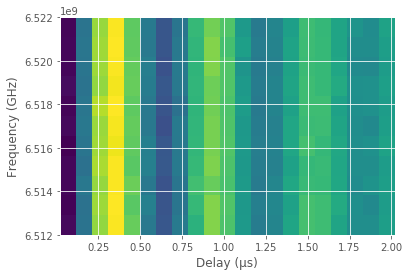

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(np.real(data), aspect='auto', extent=descriptor.extent())
plt.xlabel("Delay (µs)")
plt.ylabel("Frequency (GHz)");

## Adding Multiple Sweeps

An arbitrary number of sweeps can be added. For example:

In [25]:
exp = QubitExperiment(RabiWidth(q1,lengths),averages=50)
exp.add_qubit_sweep(q1,"measure", "frequency", np.linspace(6.512e9, 6.522e9, 5))
exp.add_qubit_sweep(q1,"measure", "amplitude", np.linspace(0.0, 1.0, 21))

Compiled 21 sequences.


If we inspect the internal representation of the "output connector" into which the instrument driver will dump its data, we can see all of the axes it contains.

In [26]:
exp.output_connectors["q1"].descriptor.axes

[<SweepAxis(name=q1 measure amplitude,length=21,unit=None,value=0.0,unstructured=False>,
 <SweepAxis(name=q1 measure frequency,length=5,unit=None,value=6512000000.0,unstructured=False>,
 <DataAxis(name=averages, start=0, stop=49, num=50, unit=None)>,
 <DataAxis(name=delay, start=0.02, stop=2.02, num=21, unit=us)>,
 <DataAxis(name=time, start=0.0, stop=2.046e-06, num=1024, unit=None)>]

The `DataAxis` entries are "baked in" using hardware looping, while the `SweepAxis` entries are external software loops facilitated by Auspex.